# Practical 1
> The goal of this practical session is to build backprop from scratch and a small neural network (MLP).

Student : **Augustin Cablant**

Imports

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

code to display a network

In [3]:
# code to display a network - do not modify this cell
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    layer_colors = ["#FFCCCC", "#CCFFCC", "#CCCCFF", "#FFCC99", "#99CCFF"]
    
    def get_color(node):
        if node._op == '+': return layer_colors[0]
        elif node._op == '*': return layer_colors[1]
        elif node._op == 'tanh': return layer_colors[2]
        # Ajoutez d'autres conditions ici pour d'autres opérations ou couches
        return layer_colors[-1]  # Couleur par défaut
    
    for n in nodes:
        color = get_color(n)
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record', style='filled', fillcolor=color)
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

## Define the value class

In [25]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(other.data + self.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(other.data * self.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __pow__(self, other): # ex. 6
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, _children = (self, ), _op = f'** {other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other 

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self): # TODO ex.3
    out = Value((1 - math.exp(- 2 * self.data)) / (1 + math.exp(- 2 * self.data)), (self, ), 'tanh')

    def _backward():
      self.grad += out.grad * (1 - out.data ** 2)
    out._backward = _backward
    
    return out
    
  def exp(self): # ex.6
    out = Value(math.exp(self.data), _children = (self, ), _op = "exp")
    def _backward():
      self.grad += out.grad * out.data
    out._backward = _backward
    return out
    
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [26]:
# Exercise 1: fill in __add__ and __mul__ in the Value class to enable the following function. You should get -8.0 as a result.
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    return L

print(lol().data)

-8.0


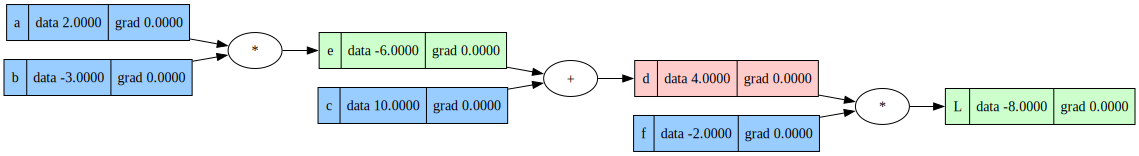

In [27]:
draw_dot(lol())

In [28]:
# Exercise 2: use the lol_grad() function below to manually compute dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

In [29]:
# report the values for dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db in this cell
# dL/df = 4.0
# etc.
lol_grad()
print("dL / df = ", 4)
print("dL / dd = ", -2)
print("dL / de = ", -2)
print("dL / dc = ", -2)
print("dL / da = ", -30)  # b x c
print("dL / db = ", 20)  # a x c

-1.9999999999953388
dL / df =  4
dL / dd =  -2
dL / de =  -2
dL / dc =  -2
dL / da =  -30
dL / db =  20


In [30]:
# Exercise 3: implement the function tanh() in the Value class and build the following network
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1z2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

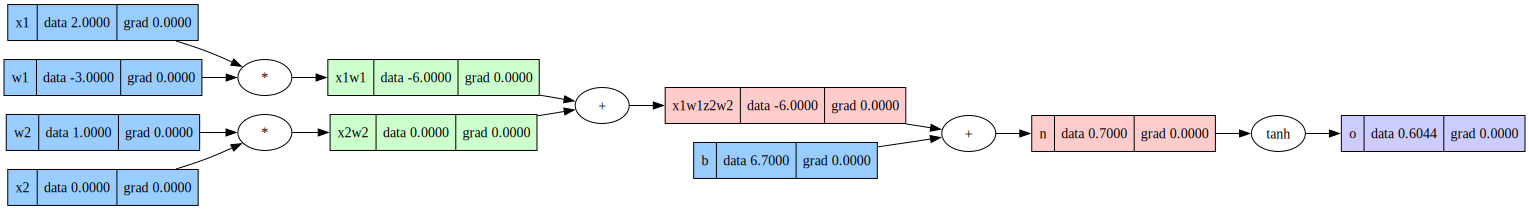

In [31]:
# o.data should be 0.6044
draw_dot(o)

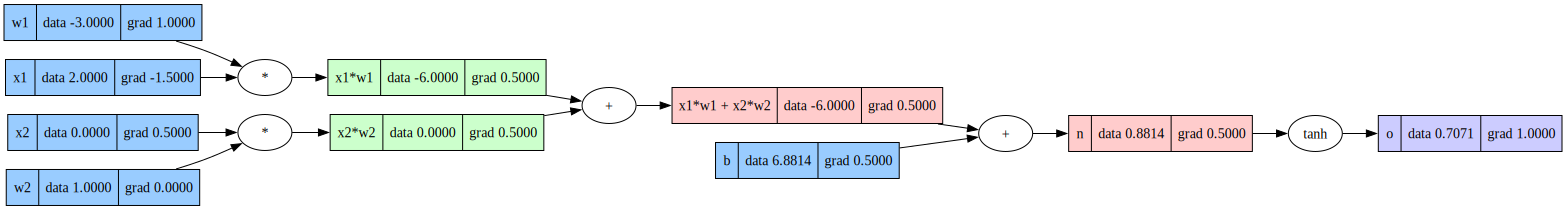

In [32]:
# Exercise 4: Implement the backward() function in each Value's operator: __add__, __mul__, __tanh__ and assign it to _backward
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
o = n.tanh()
# ----
o.label = 'o'
o.backward()
draw_dot(o)

 # expected results:
 # o.data should be 0.7071
 # w1.grad = 1.0
 # w2.grad = 0.0
 # x1.grad = -1.5
 # x2.grad = 0.5

Exercise 5 : why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. 
Hint: create a Value "a" and then b = a + a. What happens when you do b.backward()?

Answer : We use self.grad += because we want to add the gradients from all paths that lead to the output, not just from the last operation.

In [33]:
# Exercise 5: why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. 
# Hint: create a Value "a" and then b = a + a. What happens when you do b.backward()?
a = Value(2.5, label = "a")
b = a.__add__(a)
b.backward()
print(b.grad)

1.0


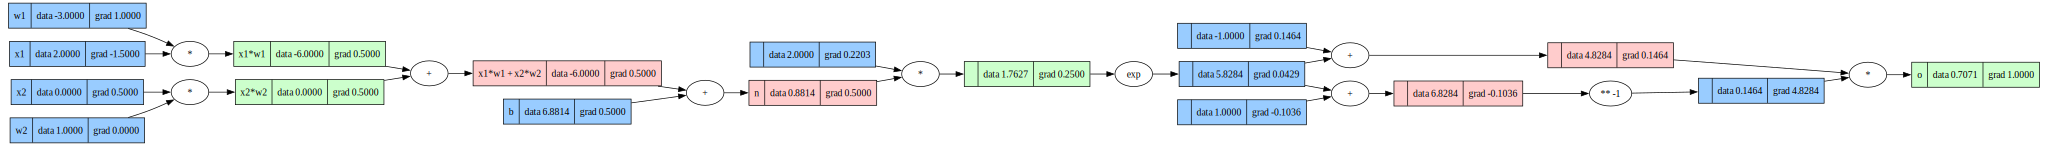

In [34]:
# Exercise 6: replace the tanh() function by a combination of exp() and division.  Implement the __exp__ and __pow__ functions in Value. You should get the same results as before.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = ... (no tanh allowed)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [35]:
# Congratulations!  You "unlocked" the basic layer of pytorch.  Now you know what happens under the hood of the following code. Check that you get the same output as before for grad values.

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [15]:
# Exercise 7: Let's build an MLP based on the Value class.  Fill in the Neuron, Layer and MLP classes.

In [36]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum([w * x[i] for i, w in enumerate(self.w)])
    act += self.b
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [param for neuron in self.neurons for param in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    self.nin = nin
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [param for layer in self.layers for param in layer.parameters()]

In [37]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.19622533825413152)

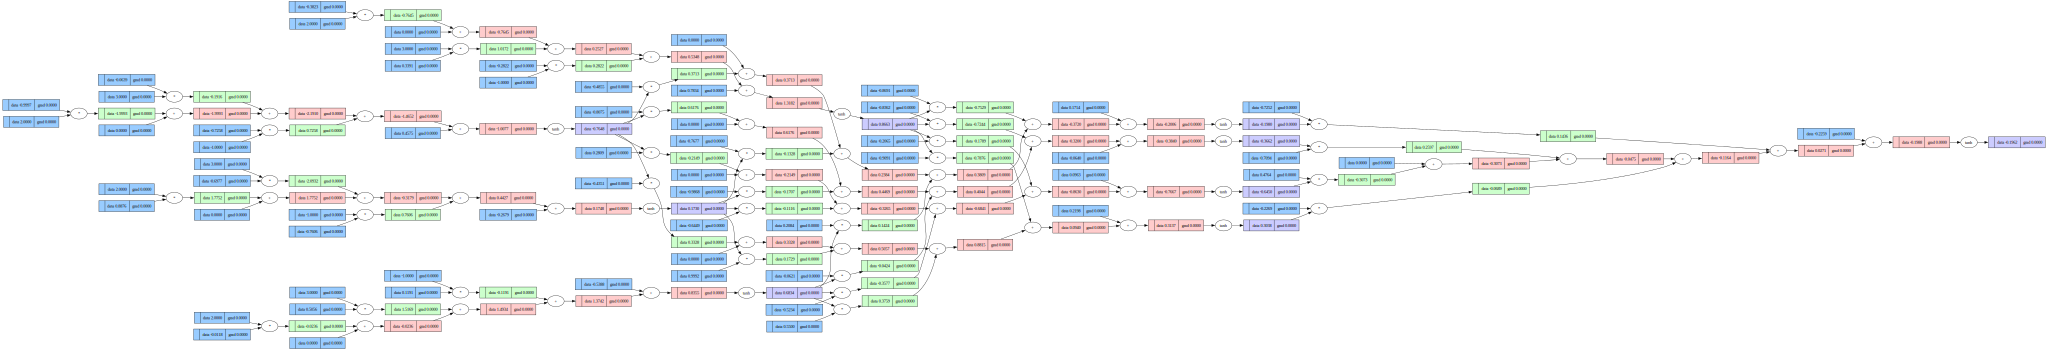

In [38]:
draw_dot(n(x))

In [19]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [20]:
len(n.parameters())

3

In [39]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.19622533825413152),
 Value(data=-0.7857351602482594),
 Value(data=-0.6935957899646494),
 Value(data=0.6756197437757476)]

In [40]:
loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)])
loss

Value(data=1.6759705719905493)

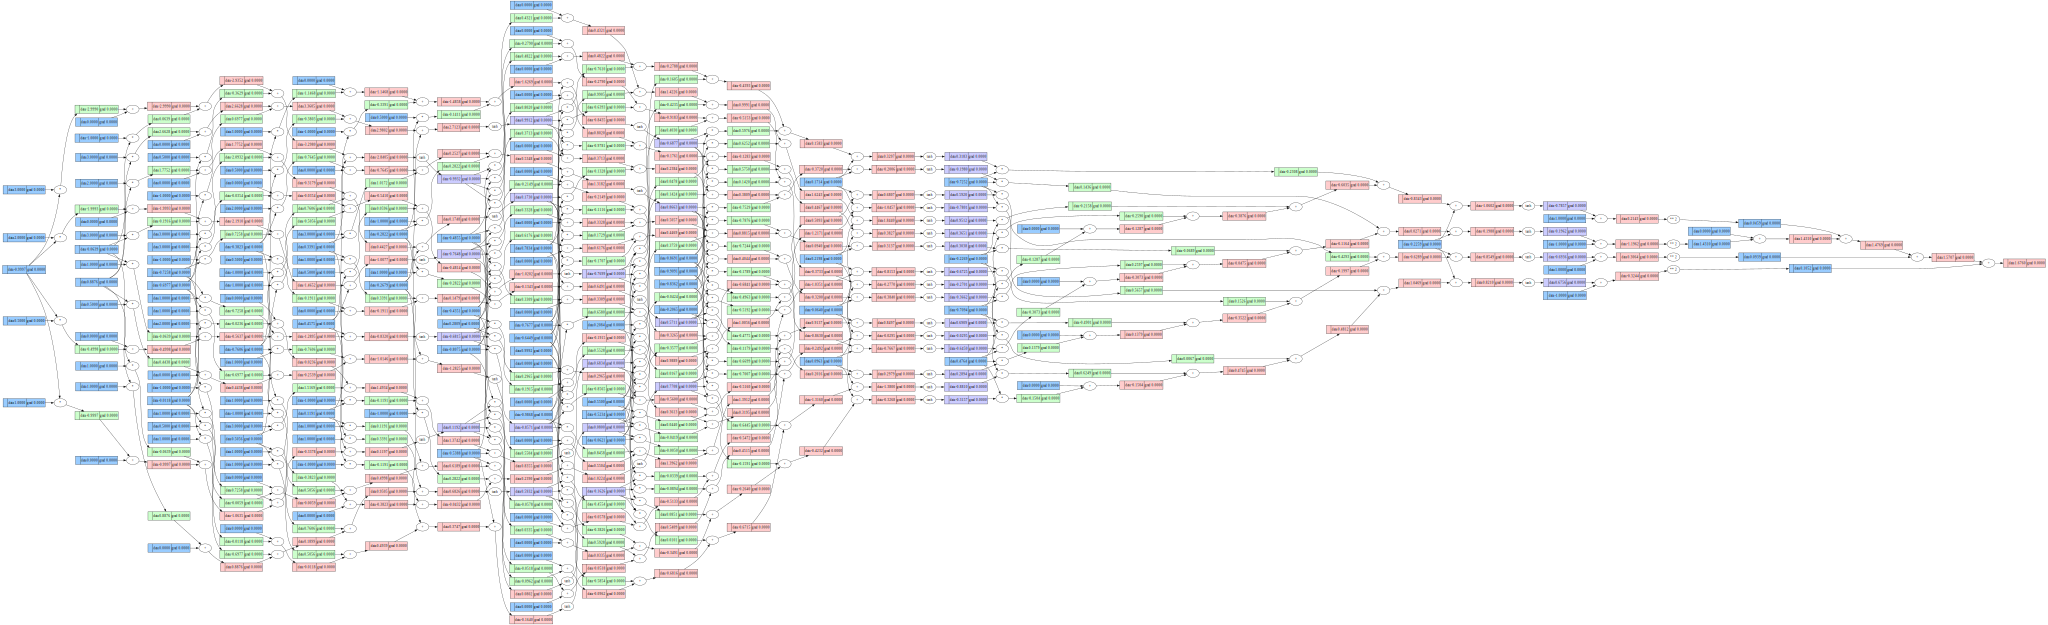

In [41]:
# see how a simple MLP can yield a complex graph already
draw_dot(loss)

In [43]:
# Exercise 8: write a training loop
for k in range(20):
    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss = sum([(a-b) ** 2 for (a,b) in zip(ypred, ys)])  # MSE between ypred and ground-truth
    #backward pass 
    for param in n.parameters():
        param.grad = float(0)
    loss.backward()
    # update
    for param in n.parameters():
        param.data -= 1e-3 * param.grad
    print(k, loss.data)

0 0.163507959598193
1 0.16279599929164562
2 0.16208971046057577
3 0.1613890285709512
4 0.1606938900424956
5 0.1600042322312128
6 0.1593199934122976
7 0.15864111276342477
8 0.15796753034840497
9 0.15729918710119628
10 0.15663602481026723
11 0.1559779861032966
12 0.1553250144322039
13 0.15467705405850318
14 0.15403405003896917
15 0.15339594821160976
16 0.1527626951819366
17 0.1521342383095259
18 0.1515105256948632
19 0.15089150616646327


In [ ]:
# Exercise 9: why do you need to reset the grads to zero at every training step?  Answer as a comment in this cell.

Exercise 9: why do you need to reset the grads to zero at every training step?  Answer as a comment in this cell.

Answer : We need to reset the grads to zero at every training step because this time we want to keep the gradients from different batches, not sum them up.

In [47]:
# Exercise 10 (*): try to approximate the n^2 function with a 2-layer MLP.  why is it so hard?

import torch.nn as nn
import torch.optim as optim

# First, we define the MLP (we use PyTorch)
class MLP(nn.Module):
    def __init__(self, activation = 'tanh'):
        super(MLP, self).__init__()
        if activation == 'tanh':
            self.layers = nn.Sequential(
                                        nn.Linear(1, 64),
                                        nn.Tanh(),
                                        nn.Linear(64, 64),
                                        nn.Tanh(),
                                        nn.Linear(64, 1)
                                        )
        elif activation == 'relu':
            self.layers = nn.Sequential(
                                        nn.Linear(1, 64),
                                        nn.ReLU(),
                                        nn.Linear(64, 64),
                                        nn.ReLU(),
                                        nn.Linear(64, 1)
                                        )

    def forward(self, x):
        return self.layers(x)

# Create the model
model = MLP(activation = 'tanh')

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

# Generate the data
x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
y = x ** 2

# Train the model
for epoch in range(1000):
    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, y)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [100/1000], Loss: 1549.6696
Epoch [200/1000], Loss: 1046.8685
Epoch [300/1000], Loss: 760.9539
Epoch [400/1000], Loss: 574.6645
Epoch [500/1000], Loss: 444.6477
Epoch [600/1000], Loss: 342.4557
Epoch [700/1000], Loss: 268.4677
Epoch [800/1000], Loss: 212.5323
Epoch [900/1000], Loss: 169.3907
Epoch [1000/1000], Loss: 135.7121


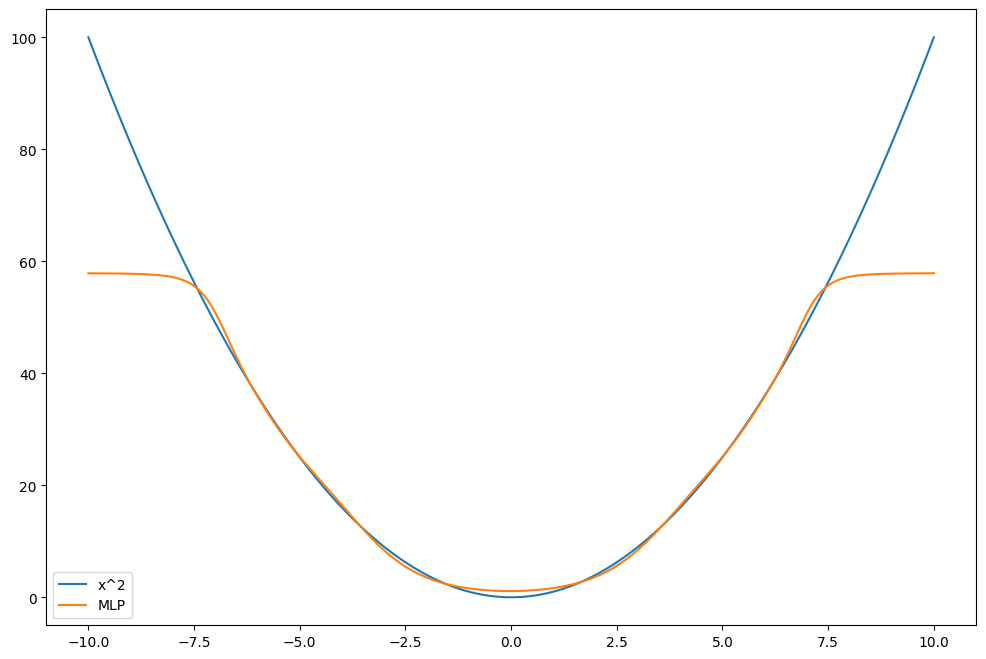

In [48]:
# Generate some test data
x_test = torch.linspace(-10, 10, 1000).reshape(-1, 1)

# Compute the outputs of the MLP
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Don't compute gradients for the testing phase 
    y_test = model(x_test)

# Convert tensors to numpy arrays for plotting
x_test = x_test.numpy()
y_test = y_test.numpy()

# Plot the original n^2 function
plt.figure(figsize = (12,8))
plt.plot(x_test, x_test ** 2, label = 'x^2')

# Plot the approximation from the MLP
plt.plot(x_test, y_test, label = 'MLP')
plt.legend()
plt.show()

Using ReLU activation function instead of tanh, we can approximate the $x^2$ function with a 2-layer MLP.

The reason why it is so hard to approximate the $x^2$ function with a 2-layer MLP using tanh is because the tanh function is bounded between -1 and 1, and the $x^2$ function is unbounded.

On the other hand, the ReLU function is unbounded and can capture the non-linearities of the $x^2$ function.

In [49]:
# Create the model
model2 = MLP(activation = 'relu')

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr = 1e-3)

# Generate the data
x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
y = x ** 2

# Train the model
for epoch in range(1000):
    # Forward pass
    outputs = model2(x)
    loss = criterion(outputs, y)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

Epoch [100/1000], Loss: 168.7205
Epoch [200/1000], Loss: 113.6444
Epoch [300/1000], Loss: 75.3357
Epoch [400/1000], Loss: 48.6736
Epoch [500/1000], Loss: 35.6538
Epoch [600/1000], Loss: 26.5384
Epoch [700/1000], Loss: 19.2113
Epoch [800/1000], Loss: 13.3220
Epoch [900/1000], Loss: 8.4341
Epoch [1000/1000], Loss: 5.0350


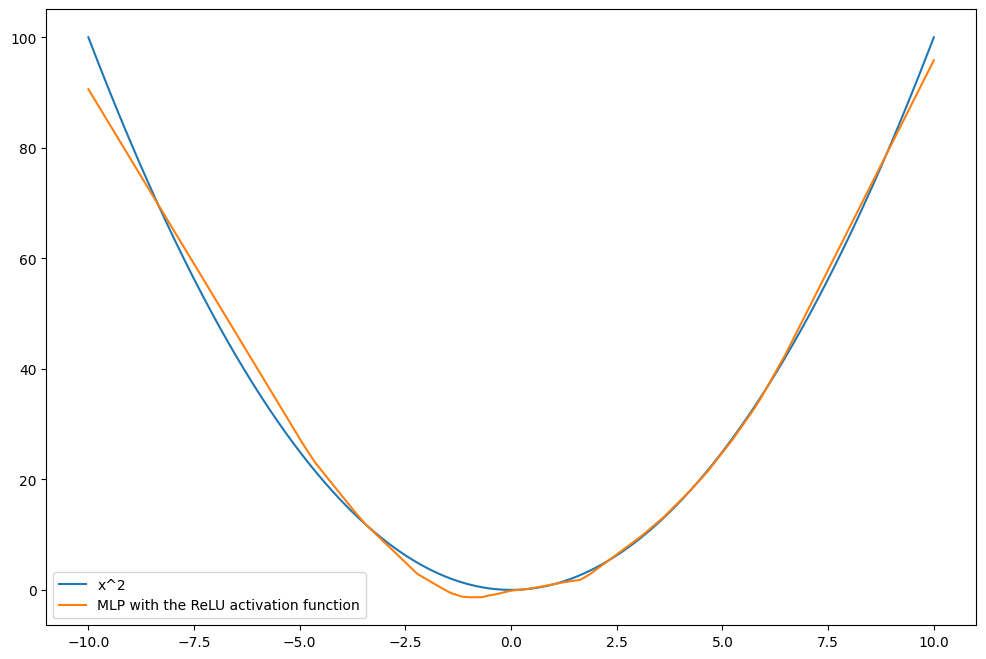

In [51]:
# Generate some test data
x_test = torch.linspace(-10, 10, 1000).reshape(-1, 1)

# Compute the outputs of the MLP
model2.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Don't compute gradients (testing phase)
    y_test = model2(x_test)

# Convert tensors to numpy arrays for plotting
x_test = x_test.numpy()
y_test = y_test.numpy()

# Plot the original x^2 function
plt.figure(figsize = (12,8))
plt.plot(x_test, x_test ** 2, label='x^2')

# Plot the approximation from the MLP
plt.plot(x_test, y_test, label = 'MLP with the ReLU activation function')
plt.legend()
plt.show()

END